In [1]:
import os
import numpy as np
import pandas as pd 
import collections
import datetime
from matplotlib import pyplot as plt

In [ ]:
PATH = '.'

Check average time elapsed from time point 1 to each other time point

In [26]:
def get_timestamp_df(df, whichtime):
    assert whichtime in ['ImagingDiffusion.Main.VisitDate', 'ImagingDiffusion.Image Information.ImgStdyDateTime'] 
    time_record = collections.defaultdict(dict)
    for index, row in df.iterrows():
        # guid + subjectId would be unique identifier
        # could be same subject (guid) has multiple mTBI record (subjectId)
        guid, subjectId = row['ImagingDiffusion.Main.GUID'], row['ImagingDiffusion.Main.SubjectIDNum']
        primaryKey = guid+'-'+str(int(subjectId))
        # extract timepoint and time
        timepoint = row['ImagingDiffusion.Main.GeneralNotesTxt']
        time = row[whichtime]
        # save timepoint to record
        # could be multiple entry for the same timepoint, since there might be multiple scanning with difference sequencing
        #if timepoint in time_record[primaryKey]:
        #    print(f'warning: has duplicate entry: {primaryKey}-{timepoint}')
        time_record[primaryKey][timepoint] = datetime.datetime.strptime(time, '%Y-%m-%dT%H:%M:%SZ') 
        # convert to dataframe
    df_out = pd.DataFrame(time_record).transpose()
    df_out = df_out[['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']]
    return df_out

def get_timelap_mean_std(df_timelap):
    timplap = {}
    for key in df_timelap.columns[1:]:
        diffs = (df_timelap[key] - df_timelap['24-48 hours']).dropna()
        diffs_days = [diff.days for diff in diffs if diff]
        timplap[key] = dict(mean=np.mean(diffs_days), std=np.std(diffs_days), 
                            minv=np.min(diffs_days), maxv=np.max(diffs_days))
    return timplap

In [2]:
# read the dti data we have
avail_dti_info = pd.read_csv('./dti_info.csv')
# read all the dti data
all_dti_info = pd.read_csv('./all_dti_info.csv')


In [34]:
# add sub control id 
avail_dti_info['cohort'] = avail_dti_info['ImagingDiffusion.Main.GUID'].apply(lambda x: 1*(x in allcontrol1ids) + 2*(x in allcontrol2ids)) * (avail_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Control')
#avail_dti_info.to_csv('./dti_info.csv')


len(set(avail_dti_info['ImagingDiffusion.Main.GUID'].values))

# add sub control id 
all_dti_info = all_dti_info.dropna(subset=['ImagingDiffusion.Main.GUID'])
all_dti_info['cohort'] = all_dti_info['ImagingDiffusion.Main.GUID'].apply(lambda x: 1*(x in allcontrol1ids) + 2*(x in allcontrol2ids)) * (all_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Control')
#all_dti_info.to_csv('./all_dti_info.csv')



In [3]:
# make sure cohort and control/case match, guid has overlap between control1 and 
print(np.unique(all_dti_info[all_dti_info['cohort'] == 0]['ImagingDiffusion.Main.CaseContrlInd'].values))
print(np.unique(all_dti_info[all_dti_info['cohort'] == 1]['ImagingDiffusion.Main.CaseContrlInd'].values))
print(np.unique(all_dti_info[all_dti_info['cohort'] == 2]['ImagingDiffusion.Main.CaseContrlInd'].values))

['Case']
['Control']
['Control']


In [4]:
print(np.unique(avail_dti_info[avail_dti_info['cohort'] == 0]['ImagingDiffusion.Main.CaseContrlInd'].values))
print(np.unique(avail_dti_info[avail_dti_info['cohort'] == 1]['ImagingDiffusion.Main.CaseContrlInd'].values))
print(np.unique(avail_dti_info[avail_dti_info['cohort'] == 2]['ImagingDiffusion.Main.CaseContrlInd'].values))

['Case']
['Control']
['Control']


In [5]:
avail_dti_info.shape

(1054, 160)

In [6]:
np.unique(avail_dti_info['cohort'], return_counts=True)

(array([0, 1, 2]), array([354, 319, 381]))

Check Number of Timestamp 

In [39]:
def get_comb_keys_dti(data):
    timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
    dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        data.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
    dti_keys = set(dti_keys)
    return dti_keys 

In [40]:
def get_scans(df):
    scans = []
    for i in range(3):
        print(f"cohort{i}:")
        data = df.loc[df['cohort'] == i]
        dti_keys = get_comb_keys_dti(data)
        print(len(dti_keys))
        d = collections.defaultdict(list)
        for key in dti_keys:
            d[key[:-2]].append(key[-1])
        print("subejct num")
        print(len(d))
        scans.append(d)
    return scans

In [41]:
def get_scans_general(df):
    scans = []
    for i in range(3):
        print(f"cohort{i}:")
        data = df.loc[df['cohort'] == i]
        dti_keys = set(data['key'].values)
        print(len(dti_keys))
        d = collections.defaultdict(list)
        for key in dti_keys:
            d[key[:-2]].append(key[-1])
        print("subejct num")
        print(len(d))
        scans.append(d)
    return scans

In [42]:
scans = get_scans(all_dti_info)
for i in range(3):
    print(f"cohort{i}:")
    scan = scans[i]
    x = [tuple(sorted(v)) for k, v in scan.items()]
    count = list(zip(*np.unique(x, return_counts=True)))
    for i in count:
        print(i)

cohort0:
365
subejct num
131
cohort1:
366
subejct num
103
cohort2:
341
subejct num
101
cohort0:
(('0',), 11)
(('0', '1'), 13)
(('0', '1', '2'), 11)
(('0', '1', '2', '3'), 41)
(('0', '1', '3'), 14)
(('0', '2'), 3)
(('0', '2', '3'), 7)
(('0', '3'), 3)
(('1',), 7)
(('1', '2'), 5)
(('1', '2', '3'), 9)
(('1', '3'), 1)
(('2',), 1)
(('2', '3'), 4)
(('3',), 1)
cohort1:
(('0',), 1)
(('0', '1'), 2)
(('0', '1', '2'), 23)
(('0', '1', '2', '3'), 67)
(('0', '1', '3'), 3)
(('0', '2'), 1)
(('1',), 1)
(('1', '2'), 1)
(('1', '2', '3'), 3)
(('2',), 1)
cohort2:
(('0',), 3)
(('0', '1'), 3)
(('0', '1', '2'), 26)
(('0', '1', '2', '3'), 58)
(('0', '2'), 3)
(('1',), 1)
(('1', '2'), 2)
(('1', '2', '3'), 3)
(('2',), 2)


/gpfs/home/Jc7489/miniconda3/envs/research/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [43]:
for i in range(3):
    print(f'cohort: {i}')
    scan = scans[i]
    timepoints = sum ([v for v in scan.values()], [])
    print(list(zip(*np.unique(timepoints, return_counts=True))))

cohort: 0
[('0', 103), ('1', 101), ('2', 81), ('3', 80)]
cohort: 1
[('0', 97), ('1', 100), ('2', 96), ('3', 73)]
cohort: 2
[('0', 93), ('1', 93), ('2', 94), ('3', 61)]


In [45]:
whichtime = 'ImagingDiffusion.Main.VisitDate' # ImagingDiffusion.Main.VisitDate' 
for i, df in enumerate([all_dti_info, avail_dti_info]):
    print(['all dti', 'avail dti'][i]+":")
    # choose only cases
    df = df.loc[df['cohort']==0]    
    # drop b0-field map: row which does not have GUID 
    df = df.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID'])
    print(f'{df.shape[0]} non b0-field map scans')
    # get time table
    df_timelap = get_timestamp_df(df, whichtime)
    # get stat of timeelap
    timelap_stat = get_timelap_mean_std(df_timelap)
    print(timelap_stat)
    

all dti:
606 non b0-field map scans
{'Asymptomatic': {'mean': 8.544303797468354, 'std': 7.014988416953059, 'minv': 1, 'maxv': 40}, '7 days Post-Unrestricted Return to Play': {'mean': 24.161290322580644, 'std': 12.88559279043359, 'minv': 8, 'maxv': 94}, '6 months post-injury': {'mean': 178.8153846153846, 'std': 26.140385676451093, 'minv': 50, 'maxv': 245}}
avail dti:
354 non b0-field map scans
{'Asymptomatic': {'mean': 9.0, 'std': 6.263808275933025, 'minv': 2, 'maxv': 25}, '7 days Post-Unrestricted Return to Play': {'mean': 26.892857142857142, 'std': 16.377988899989013, 'minv': 8, 'maxv': 94}, '6 months post-injury': {'mean': 185.5, 'std': 14.729707590929486, 'minv': 150, 'maxv': 245}}


Check SCAT3 at different timepoint

In [50]:
all_SCAT3 = pd.read_csv('../common_data/query_result_SCAT3_2019-07-17T15-31-366293200903750909084.csv', low_memory=False)
all_SCAT3['cohort'] = all_SCAT3['SCAT3.Main.GUID'].apply(lambda x: 1*(x in allcontrol1ids) + 2*(x in allcontrol2ids)) * (all_SCAT3['SCAT3.Main.CaseContrlInd'] == 'Control')

timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
SoIs = ['SCAT3.Symptom Evaluation.Scat3BlurryVision', 'SCAT3.Scoring Summary.Scat3TotalSymptoms', 'SCAT3.Scoring Summary.Scat3TotSympScore']
case_control = ['Case', 'Control']

In [51]:
def score_stat(df, timepoint_key, timepoints):
    for i in range(0,3):
        print(f"cohort {i}")
        df_cohort = df.loc[df['cohort'] == i]
        for timepoint in timepoints:
            print(timepoint+":")
            stat = {}
            df_t = df_cohort.loc[df_cohort[timepoint_key] == timepoint]
            for SoI in SoIs:
                print(SoI)
                df_score = df_t[SoI]
                df_score = df_score.dropna().to_list()
                print(len(df_score))
                stat = dict(mean=np.mean(df_score),
                            std=np.std(df_score),
                            minv=np.min(df_score),
                            maxv=np.max(df_score))
                print(SoI)
                print(f"{', '.join([f'{k} : {v}' for k, v in stat.items()])}")
        
    
    

In [53]:
dti_info = all_dti_info #all_dti_info

timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
dti_keys = set(dti_keys)

timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
all_SCAT3_4t = all_SCAT3.loc[all_SCAT3['SCAT3.Form Administration.ContextTypeOTH'].isin(timepoints)]

keys = all_SCAT3_4t['SCAT3.Main.GUID'] +'-'+  \
all_SCAT3_4t['SCAT3.Main.SubjectIDNum'].apply(lambda x:str(int(x)))+'-'+\
all_SCAT3_4t['SCAT3.Form Administration.ContextTypeOTH'].apply(lambda x:str(timepoints.index(x)))
all_SCAT3_4t = all_SCAT3_4t.assign(key = keys)

dti_SCAT_4t = all_SCAT3_4t.loc[all_SCAT3_4t['key'].isin(dti_keys)]
print(f'SCAT3/dMRI {dti_SCAT_4t.shape[0]}/{len(dti_keys)} overlapped')
dti_SCAT_4t.to_csv('all_dti_SCAT3_overlap.csv')

SCAT3/dMRI 923/1072 overlapped


In [59]:
def get_scans_general(df ,key='key'):
    scans = []
    for i in range(3):
        print(f"cohort{i}:")
        data = df.loc[df['cohort'] == i]
        dti_keys = set(data[key].values)
        print(len(data[key].values))
        print(len(dti_keys))
        d = collections.defaultdict(list)
        for dti_key in dti_keys:
            d[dti_key[:-2]].append(dti_key[-1])
        print("subejct num")
        print(len(d))
        scans.append(d)
    return scans

In [60]:
np.unique(dti_SCAT_4t['cohort'], return_counts=True)

(array([0, 1, 2]), array([155, 125, 124]))

In [61]:
scans = get_scans_general(dti_SCAT_4t)
for i in range(3):
    print(f"cohort{i}:")
    scan = scans[i]
    x = [tuple(sorted(v)) for k, v in scan.items()]
    count = list(zip(*np.unique(x, return_counts=True)))
    for i in count:
        print(i)

cohort0:
155
155
subejct num
61
cohort1:
125
125
subejct num
39
cohort2:
124
124
subejct num
39
cohort0:
(('0',), 8)
(('0', '1'), 6)
(('0', '1', '2'), 3)
(('0', '1', '2', '3'), 17)
(('0', '1', '3'), 5)
(('0', '2', '3'), 3)
(('0', '3'), 1)
(('1',), 8)
(('1', '2'), 2)
(('1', '2', '3'), 4)
(('1', '3'), 2)
(('2', '3'), 2)
cohort1:
(('0',), 1)
(('0', '1'), 3)
(('0', '1', '2'), 5)
(('0', '1', '2', '3'), 17)
(('0', '1', '3'), 9)
(('0', '2'), 1)
(('0', '3'), 1)
(('1', '2', '3'), 1)
(('3',), 1)
cohort2:
(('0',), 1)
(('0', '1'), 2)
(('0', '1', '2'), 8)
(('0', '1', '2', '3'), 17)
(('0', '1', '3'), 5)
(('0', '2'), 2)
(('0', '3'), 1)
(('1', '2'), 1)
(('1', '2', '3'), 1)
(('2',), 1)


/gpfs/home/Jc7489/miniconda3/envs/research/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [62]:
for i in range(3):
    print(f'cohort: {i}')
    scan = scans[i]
    timepoints = sum ([v for v in scan.values()], [])
    print(list(zip(*np.unique(timepoints, return_counts=True))))

cohort: 0
[('0', 43), ('1', 47), ('2', 31), ('3', 34)]
cohort: 1
[('0', 37), ('1', 35), ('2', 24), ('3', 29)]
cohort: 2
[('0', 36), ('1', 34), ('2', 30), ('3', 24)]


In [296]:
print("all CARE data statistics")
score_stat(dti_SCAT_4t, 
           timepoint_key='SCAT3.Form Administration.ContextTypeOTH', 
           timepoints=['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury'])

all CARE data statistics
cohort 0
24-48 hours:
SCAT3.Symptom Evaluation.Scat3BlurryVision
43
SCAT3.Symptom Evaluation.Scat3BlurryVision
mean : 0.6511627906976745, std : 1.2367196093310076, minv : 0.0, maxv : 5.0
SCAT3.Scoring Summary.Scat3TotalSymptoms
41
SCAT3.Scoring Summary.Scat3TotalSymptoms
mean : 12.24390243902439, std : 5.498472017485151, minv : 0.0, maxv : 22.0
SCAT3.Scoring Summary.Scat3TotSympScore
43
SCAT3.Scoring Summary.Scat3TotSympScore
mean : 27.209302325581394, std : 20.205408140344545, minv : 0.0, maxv : 83.0
Asymptomatic:
SCAT3.Symptom Evaluation.Scat3BlurryVision
47
SCAT3.Symptom Evaluation.Scat3BlurryVision
mean : 0.0, std : 0.0, minv : 0.0, maxv : 0.0
SCAT3.Scoring Summary.Scat3TotalSymptoms
38
SCAT3.Scoring Summary.Scat3TotalSymptoms
mean : 1.394736842105263, std : 1.8713838629011608, minv : 0.0, maxv : 8.0
SCAT3.Scoring Summary.Scat3TotSympScore
47
SCAT3.Scoring Summary.Scat3TotSympScore
mean : 1.4042553191489362, std : 2.3124047947563446, minv : 0.0, maxv : 11.0

In [284]:
a = dti_SCAT_4t.loc[dti_SCAT_4t['cohort'] == 0]
#a = a.loc[a['SCAT3.Form Administration.ContextTypeOTH'] == timepoints[0]]
a.shape

(315, 133)

In [286]:
timepoints[0]

'0'

In [82]:
avail_dti_info = pd.read_csv('./dti_info.csv')

timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        avail_dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
avail_dti_info['key'] =  dti_keys

In [86]:
avail_dti_info=avail_dti_info.drop_duplicates(subset=['key'])

In [92]:
a = avail_dti_info.loc[avail_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Case']

In [93]:
list(zip(*np.unique([x.split('-')[-1] for x in a['key'].values], return_counts=True)))

[('0', 46), ('1', 50), ('2', 39), ('3', 36)]

In [91]:
dti_SCAT_4t.loc[dti_SCAT_4t['SCAT3.Main.CaseContrlInd'] == 'Control'].shape

(244, 133)

In [78]:
a = dti_SCAT_4t.loc[dti_SCAT_4t['SCAT3.Main.CaseContrlInd'] == 'Control']

In [79]:
np.unique(a['key'].apply(lambda x: int(x.split('-')[-1])), return_counts=True)

(array([0, 1, 2, 3]), array([71, 67, 53, 53]))

In [95]:
dti_SCAT_4t

,Unnamed: 0,Study ID,Dataset,SCAT3.Main.GUID,SCAT3.Main.SubjectIDNum,SCAT3.Main.AgeYrs,SCAT3.Main.VitStatus,SCAT3.Main.VisitDate,SCAT3.Main.SiteName,SCAT3.Main.DaysSinceBaseline,...,SCAT3.Scoring Summary.SACImmdMemorySubsetScore,SCAT3.Scoring Summary.SACImmdMemoryTrialScore,SCAT3.Scoring Summary.SACConcentationSubsetScore,SCAT3.Scoring Summary.SACDelayedRecallSubsetScore,SCAT3.Scoring Summary.SACTotalScore,SCAT3.Scoring Summary.BESSTotalErrorCt,SCAT3.Scoring Summary.FullTandemStandDur,SCAT3.Scoring Summary.SCAT3UpperLimbCoordinatScore,SCAT3.Scoring Summary.GeneralNotesTxt,key
0,45,310,FITBIR-DATA0006128,TBIBP604ERQ,2285,NaN,Alive,2017-02-28T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIBP604ERQ-2285-1
1,166,310,FITBIR-DATA0006128,TBIUJ419GBT,2387,NaN,Alive,2017-04-10T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIUJ419GBT-2387-1
2,217,310,FITBIR-DATA0006128,TBIBP604ERQ,2285,NaN,Alive,2017-08-28T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIBP604ERQ-2285-3
3,288,310,FITBIR-DATA0006128,TBIHZ208WEK,2417,NaN,Alive,2017-03-23T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIHZ208WEK-2417-0
4,504,310,FITBIR-DATA0006128,TBIHC882EW2,2371,NaN,Alive,2017-03-13T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIHC882EW2-2371-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,61649,310,FITBIR-DATA0006128,TBIZA241JFR,2258,NaN,Alive,2017-03-03T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIZA241JFR-2258-2
400,61655,310,FITBIR-DATA0006128,TBIVW194XGD,2078,NaN,Alive,2017-01-30T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIVW194XGD-2078-2
401,61692,310,FITBIR-DATA0006128,TBIVX914PTT,2101,NaN,Alive,2017-02-13T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIVX914PTT-2101-2
402,61713,310,FITBIR-DATA0006128,TBIYF961HX3,2079,NaN,Alive,2017-01-18T00:00:00Z,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TBIYF961HX3-2079-1


In [11]:
print("vail CARE data")
score_stat(dti_SCAT_4t)

vail CARE data
Case:
24-48 hours:
SCAT3.Symptom Evaluation.Scat3BlurryVision
mean : 0.6444444444444445, std : 1.2139111363331256, minv : 0.0, maxv : 5.0
SCAT3.Scoring Summary.Scat3TotalSymptoms
mean : 12.511627906976743, std : 5.508437895410395, minv : 0.0, maxv : 22.0
SCAT3.Scoring Summary.Scat3TotSympScore
mean : 27.08888888888889, std : 19.766213847789448, minv : 0.0, maxv : 83.0
Asymptomatic:
SCAT3.Symptom Evaluation.Scat3BlurryVision
mean : 0.0, std : 0.0, minv : 0.0, maxv : 0.0
SCAT3.Scoring Summary.Scat3TotalSymptoms
mean : 1.375, std : 1.839667089448523, minv : 0.0, maxv : 8.0
SCAT3.Scoring Summary.Scat3TotSympScore
mean : 1.3877551020408163, std : 2.2751212260198828, minv : 0.0, maxv : 11.0
Unrestricted Return to Play:
SCAT3.Symptom Evaluation.Scat3BlurryVision
mean : 0.0, std : 0.0, minv : 0.0, maxv : 0.0
SCAT3.Scoring Summary.Scat3TotalSymptoms
mean : 0.6818181818181818, std : 2.0312639065003935, minv : 0.0, maxv : 8.0
SCAT3.Scoring Summary.Scat3TotSympScore
mean : 0.71875, 

In [51]:
recoveried = dti_SCAT_4t[dti_SCAT_4t['key'].apply(lambda x:int(x.split('-')[-1])) != 0]
#recoveried = dti_SCAT_4t
scores = recoveried.iloc[:,20:-2]
a = []
for column in scores.columns:
    col = scores[column]
    col = col.dropna()
    if len(col):
        mean = np.mean(col.values)
        a.append((column, mean))

In [94]:
SCAT3

NameError: name 'SCAT3' is not defined

How many overlap between out usable data with NP score

1) ImPACT

In [60]:
dti_info = avail_dti_info

timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
dti_keys = set(dti_keys)

Impact_append = pd.read_csv('../common_data/query_result_ImPACTAppdx0000310_2019-07-17T15-28-511261814463076333156.csv', low_memory=False)
Impact_result = pd.read_csv('../common_data/query_result_ImPACT_2019-07-17T15-28-195279178785655342848.csv', low_memory=False)
Impact_result['cohort'] = Impact_result['ImPACT.Main.GUID'].apply(lambda x: 1*(x in allcontrol1ids) + 2*(x in allcontrol2ids))

print(f'Impact appendix shape: {Impact_append.shape[0]}')
print(f'Impact data shape: {Impact_result.shape[0]}')

Impact_append_keys = Impact_append['ImPACTAppdx0000310.Main.GUID'] + '-' +\
                     Impact_append['ImPACTAppdx0000310.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_append['ImPACTAppdx0000310.Main.VisitDate']
Impact_append['key'] = Impact_append_keys
Impact_append = Impact_append.dropna(axis=0, subset=['key'])

Impact_result_keys = Impact_result['ImPACT.Main.GUID'] + '-' + \
                     Impact_result['ImPACT.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_result['ImPACT.Main.VisitDate']
Impact_result['key'] = Impact_result_keys
Impact_result = Impact_result.dropna(axis=0, subset=['key'])

print(f'Impact appendix shape: {Impact_append.shape[0]}')
print(f'Impact data shape: {Impact_result.shape[0]}')
             
merged_Impact = pd.merge(Impact_result, Impact_append, on="key")

# merged_Impact.to_csv('Impact_merged.csv')
timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
merged_Impact['ImPACTAppdx0000310.Form Administration.ContextTypeOTH'] = merged_Impact['ImPACTAppdx0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Unrestricted Return to Play' if 'restricted' in x else x)
merged_Impact['ImPACTAppdx0000310.Form Administration.ContextTypeOTH'] = merged_Impact['ImPACTAppdx0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Asymptomatic' if 'symptomatic' in x else x)
merged_Impact= merged_Impact.loc[merged_Impact['ImPACTAppdx0000310.Form Administration.ContextTypeOTH'].isin(timepoints)]
print(f'4 points Impact: {merged_Impact.shape[0]}')
keys2 = merged_Impact['ImPACT.Main.GUID'] + '-' + \
        merged_Impact['ImPACT.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
        merged_Impact['ImPACTAppdx0000310.Form Administration.ContextTypeOTH'].apply(lambda x:str(timepoints.index(x)))
merged_Impact['key2'] = keys2


merged_Impact_4t = merged_Impact.loc[merged_Impact['key2'].isin(dti_keys)]
merged_Impact_4t = merged_Impact_4t.drop_duplicates(subset='key2')
print(f'Impact/dMRI {merged_Impact_4t.shape[0]}/{len(dti_keys)} overlapped')

print('Impact')
print(list(zip(*np.unique([x.split('-')[-1] for x in merged_Impact_4t['key2'].values], return_counts=True))))
      

Impact appendix shape: 20479
Impact data shape: 47568
Impact appendix shape: 18282
Impact data shape: 47548
4 points Impact: 5778
Impact/dMRI 146/478 overlapped
Impact
[('0', 42), ('1', 38), ('2', 38), ('3', 28)]


In [61]:
np.unique(merged_Impact_4t['cohort'], return_counts=True)

(array([0, 1, 2]), array([58, 51, 37]))

In [62]:
scans = get_scans_general(merged_Impact_4t, key='key2')
for i in range(3):
    print(f"cohort{i}:")
    scan = scans[i]
    x = [tuple(sorted(v)) for k, v in scan.items()]
    count = list(zip(*np.unique(x, return_counts=True)))
    for i in count:
        print(i)

cohort0:
58
58
subejct num
25
cohort1:
51
51
subejct num
18
cohort2:
37
37
subejct num
12
cohort0:
(('0',), 5)
(('0', '1'), 1)
(('0', '1', '2'), 1)
(('0', '1', '2', '3'), 4)
(('0', '1', '3'), 1)
(('0', '2'), 1)
(('0', '2', '3'), 3)
(('0', '3'), 1)
(('1',), 3)
(('1', '2', '3'), 3)
(('2', '3'), 2)
cohort1:
(('0',), 3)
(('0', '1', '2'), 5)
(('0', '1', '2', '3'), 7)
(('1', '2'), 1)
(('2',), 1)
(('2', '3'), 1)
cohort2:
(('0', '1'), 2)
(('0', '1', '2'), 2)
(('0', '1', '2', '3'), 6)
(('1',), 1)
(('1', '2'), 1)


/gpfs/home/Jc7489/miniconda3/envs/research/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [63]:
for i in range(3):
    print(f'cohort: {i}')
    scan = scans[i]
    timepoints = sum ([v for v in scan.values()], [])
    print(list(zip(*np.unique(timepoints, return_counts=True))))

cohort: 0
[('0', 17), ('1', 13), ('2', 14), ('3', 14)]
cohort: 1
[('0', 15), ('1', 13), ('2', 15), ('3', 8)]
cohort: 2
[('0', 10), ('1', 12), ('2', 9), ('3', 6)]


In [64]:
timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
SoIs = ['ImPACT.ImPACT Test.ImPACTVisMemoryCompScore']
print("all CARE data statistics")
score_stat(merged_Impact_4t, 
           timepoint_key='ImPACTAppdx0000310.Form Administration.ContextTypeOTH', 
           timepoints=['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury'])



all CARE data statistics
cohort 0
24-48 hours:
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
17
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
mean : 68.11764705882354, std : 14.942565938171697, minv : 46, maxv : 96
Asymptomatic:
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
13
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
mean : 78.46153846153847, std : 10.731803093289408, minv : 57, maxv : 95
Unrestricted Return to Play:
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
14
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
mean : 76.78571428571429, std : 10.870527464062578, minv : 61, maxv : 96
6 m onths post-injury:
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
14
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
mean : 80.92857142857143, std : 14.464065254051828, minv : 54, maxv : 99
cohort 1
24-48 hours:
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
15
ImPACT.ImPACT Test.ImPACTVisMemoryCompScore
mean : 77.86666666666666, std : 10.518977559101877, minv : 61, maxv : 96
Asymptomatic:
ImPACT.ImPACT Test.ImPACTVisMem

In [311]:
for i in range(4):
    scores = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])) == i]['ImPACT.ImPACT Test.ImPACTVisMemoryCompScore'].values
    print(f't: {i}, len: {len(scores)}, mean{np.mean(scores)},std: {np.std(scores)}, max: {np.max(scores)}, min: {np.min(scores)}')




t: 0, len: 42, mean75.0952380952381,std: 13.80098258028775, max: 100, min: 46
t: 1, len: 39, mean75.97435897435898,std: 11.21465885825489, max: 95, min: 55
t: 2, len: 67, mean76.22388059701493,std: 12.023386285767739, max: 100, min: 48
t: 3, len: 28, mean80.71428571428571,std: 14.67227011079341, max: 100, min: 51


In [97]:
a = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])) == 3]['ImPACT.Form Administration Group.ContextTypeOTH']
np.unique(a.values)

array(['6 m onths post-injury'], dtype=object)

Check within 2 months

Text(0.5, 1.0, 'ImPACTVisMemoryCompScore')

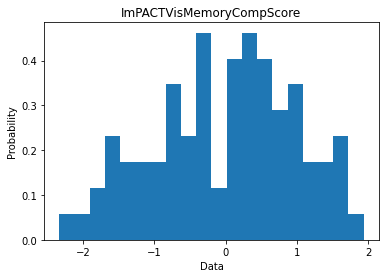

In [11]:
scores = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])).isin([0,1])]['ImPACT.ImPACT Test.ImPACTVisMemoryCompScore'].values
scores = (scores - np.mean(scores)) / np.std(scores)
plt.hist(scores, density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title('ImPACTVisMemoryCompScore')



Check at 6 months

<ipython-input-13-add6ad5082d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_Impact_4t['key3'] = merged_Impact_4t['ImPACT.Main.GUID'] +'-' + merged_Impact_4t['ImPACT.Main.SubjectIDNum'].apply(lambda x:str(int(x)))


Text(0.5, 1.0, 'ImPACTVisMemoryCompScore')

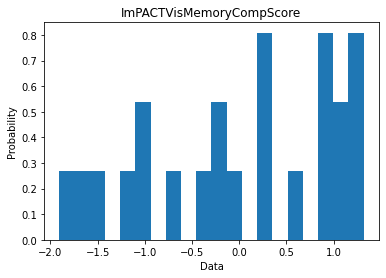

In [13]:
a = df_timelap.loc[(df_timelap['6 months post-injury'] - df_timelap['24-48 hours']).apply(lambda x:x.days) >= 60]
subjs = a.index.values
merged_Impact_4t['key3'] = merged_Impact_4t['ImPACT.Main.GUID'] +'-' + merged_Impact_4t['ImPACT.Main.SubjectIDNum'].apply(lambda x:str(int(x)))
df = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])).isin([3])]
df = df.loc[df['key3'].isin(subjs)]
scores = df['ImPACT.ImPACT Test.ImPACTVisMemoryCompScore'].values
scores = (scores - np.mean(scores)) / np.std(scores)
plt.hist(scores, density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title('ImPACTVisMemoryCompScore')



In [18]:
oldlabels = pd.read_excel('./label_154_new_subjectspace_filter_updated-2.xlsx')

rcft_d_t1 = oldlabels['RCFT Delayed T1'].values
rcft_d_t2 = oldlabels['RCFT Delayed T2'].values
scores = (scores - np.mean(scores)) / np.std(scores)


Text(0.5, 1.0, 'RCFT_D')

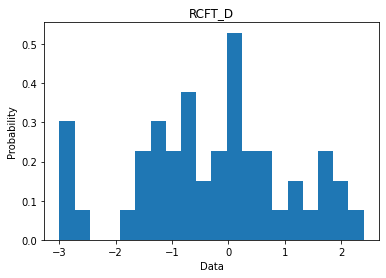

In [21]:
plt.hist(rcft_d_t2, density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title('RCFT_D')

2) VOMS

In [71]:
dti_info = all_dti_info

timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
dti_keys = set(dti_keys)

Impact_append = pd.read_csv('../common_data/query_result_VOMSAppdx0000310_2019-07-17T15-29-284351967405833249098.csv', low_memory=False)
Impact_result = pd.read_csv('../common_data/query_result_VOMS_2019-07-17T15-27-453951868808238468368.csv', low_memory=False)

TestName = "VOMS"

print(f'{TestName} appendix shape: {Impact_append.shape[0]}')
print(f'{TestName} data shape: {Impact_result.shape[0]}')

Impact_append_keys = Impact_append[f'{TestName}Appdx0000310.Main.GUID'] + '-' +\
                     Impact_append[f'{TestName}Appdx0000310.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_append[f'{TestName}Appdx0000310.Main.VisitDate']
Impact_append['key'] = Impact_append_keys
Impact_append = Impact_append.dropna(axis=0, subset=['key'])

Impact_result_keys = Impact_result[f'{TestName}.Main.GUID'] + '-' + \
                     Impact_result[f'{TestName}.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_result[f'{TestName}.Main.VisitDate']
Impact_result['key'] = Impact_result_keys
Impact_result = Impact_result.dropna(axis=0, subset=['key'])

print(f'{TestName} appendix shape: {Impact_append.shape[0]}')
print(f'{TestName} data shape: {Impact_result.shape[0]}')
             
merged_Impact = pd.merge(Impact_result, Impact_append, on="key")

# merged_Impact.to_csv('Impact_merged.csv')
timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
merged_Impact[f'{TestName}Appdx0000310.Form Administration.ContextTypeOTH'] = merged_Impact[f'{TestName}Appdx0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Unrestricted Return to Play' if 'restricted' in x else x)
merged_Impact[f'{TestName}Appdx0000310.Form Administration.ContextTypeOTH'] = merged_Impact[f'{TestName}Appdx0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Asymptomatic' if 'symptomatic' in x else x)
merged_Impact= merged_Impact.loc[merged_Impact[f'{TestName}Appdx0000310.Form Administration.ContextTypeOTH'].isin(timepoints)]
print(f'4 points Impact: {merged_Impact.shape[0]}')
keys2 = merged_Impact[f'{TestName}.Main.GUID'] + '-' + \
        merged_Impact[f'{TestName}.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
        merged_Impact[f'{TestName}Appdx0000310.Form Administration.ContextTypeOTH'].apply(lambda x:str(timepoints.index(x)))
merged_Impact['key2'] = keys2

# read dti
avail_dti_info = pd.read_csv('./dti_info.csv')
timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        avail_dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
dti_keys = set(dti_keys)

merged_Impact_4t = merged_Impact.loc[merged_Impact['key2'].isin(dti_keys)]
print(f'Impact/dMRI {merged_Impact_4t.shape[0]}/{len(dti_keys)} overlapped')

print(f'{TestName}')
print(list(zip(*np.unique([x.split('-')[-1] for x in merged_Impact_4t['key2'].values], return_counts=True))))
      

VOMS appendix shape: 8026
VOMS data shape: 8344
VOMS appendix shape: 8016
VOMS data shape: 8307
4 points Impact: 1656
Impact/dMRI 148/478 overlapped
VOMS
[('0', 30), ('1', 33), ('2', 60), ('3', 25)]


3) WTAR

In [76]:
Impact_append = pd.read_csv('../common_data/query_result_WTAR_Appdx_0000310_2019-07-17T15-27-318182784274479170284.csv', low_memory=False)
Impact_result = pd.read_csv('../common_data/query_result_WTAR_FITBIR_2019-07-17T15-29-334222066513279118754.csv', low_memory=False)
TestName = 'WTAR'
print(f'{TestName} appendix shape: {Impact_append.shape[0]}')
print(f'{TestName} data shape: {Impact_result.shape[0]}')

Impact_append_keys = Impact_append[f'{TestName}_Appdx_0000310.Main Group.GUID'] + '-' +\
                     Impact_append[f'{TestName}_Appdx_0000310.Main Group.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_append[f'{TestName}_Appdx_0000310.Main Group.VisitDate']
Impact_append['key'] = Impact_append_keys
Impact_append = Impact_append.dropna(axis=0, subset=['key'])

Impact_result_keys = Impact_result[f'{TestName}_FITBIR.Main.GUID'] + '-' + \
                     Impact_result[f'{TestName}_FITBIR.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_result[f'{TestName}_FITBIR.Main.VisitDate']
Impact_result['key'] = Impact_result_keys
Impact_result = Impact_result.dropna(axis=0, subset=['key'])

print(f'{TestName} appendix shape: {Impact_append.shape[0]}')
print(f'{TestName} data shape: {Impact_result.shape[0]}')
             
merged_Impact = pd.merge(Impact_result, Impact_append, on="key")

# merged_Impact.to_csv('Impact_merged.csv')
timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
merged_Impact[f'{TestName}_Appdx_0000310.Main Group.Form Administration.ContextTypeOTH'] = merged_Impact[f'{TestName}_Appdx_0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Unrestricted Return to Play' if 'restricted' in x else x)
merged_Impact[f'{TestName}_Appdx_0000310.Main Group.Form Administration.ContextTypeOTH'] = merged_Impact[f'{TestName}_Appdx_0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Asymptomatic' if 'symptomatic' in x else x)
merged_Impact= merged_Impact.loc[merged_Impact[f'{TestName}_Appdx_0000310.Form Administration.ContextTypeOTH'].isin(timepoints)]
print(f'4 points Impact: {merged_Impact.shape[0]}')
keys2 = merged_Impact[f'{TestName}_FITBIR.Main.GUID'] + '-' + \
        merged_Impact[f'{TestName}_FITBIR.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
        merged_Impact[f'{TestName}_Appdx_0000310.Form Administration.ContextTypeOTH'].apply(lambda x:str(timepoints.index(x)))
merged_Impact['key2'] = keys2

# read dti
avail_dti_info = pd.read_csv('./dti_info.csv')
timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        avail_dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
dti_keys = set(dti_keys)

merged_Impact_4t = merged_Impact.loc[merged_Impact['key2'].isin(dti_keys)]
print(f'Impact/dMRI {merged_Impact_4t.shape[0]}/{len(dti_keys)} overlapped')

print(f'{TestName}')
print(list(zip(*np.unique([x.split('-')[-1] for x in merged_Impact_4t['key2'].values], return_counts=True))))
      

WTAR appendix shape: 8454
WTAR data shape: 7549
WTAR appendix shape: 6671
WTAR data shape: 7436
4 points Impact: 0
Impact/dMRI 0/478 overlapped
WTAR
[]


4) CNSDomainSco

In [76]:
dti_info = avail_dti_info

timepoints = ['24-48 hours', 'Asymptomatic', '7 days Post-Unrestricted Return to Play', '6 months post-injury']
dti_keys = ['-'.join([row['ImagingDiffusion.Main.GUID'], str(int(row['ImagingDiffusion.Main.SubjectIDNum'])), str(timepoints.index(row['ImagingDiffusion.Main.GeneralNotesTxt']))])
        for i, row in 
        dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID']).iterrows()]
dti_keys = set(dti_keys)

Impact_append = pd.read_csv('../common_data/query_result_CNSDomainSco_Appdx_0000310_2019-07-17T15-35-036390222589639853506.csv', low_memory=False)
Impact_result = pd.read_csv('../common_data/query_result_CNSVitalSignsDomainScores_2019-07-17T15-35-024178106461638423806.csv', low_memory=False)

TestName = "CNS"
Impact_result['cohort'] = Impact_result['CNSVitalSignsDomainScores.Main.GUID'].apply(lambda x: 1*(x in allcontrol1ids) + 2*(x in allcontrol2ids))

print(f'{TestName} appendix shape: {Impact_append.shape[0]}')
print(f'{TestName} data shape: {Impact_result.shape[0]}')

Impact_append_keys = Impact_append[f'CNSDomainSco_Appdx_0000310.Main.GUID'] + '-' +\
                     Impact_append[f'CNSDomainSco_Appdx_0000310.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_append[f'CNSDomainSco_Appdx_0000310.Main.VisitDate']
Impact_append['key'] = Impact_append_keys
Impact_append = Impact_append.dropna(axis=0, subset=['key'])

Impact_result_keys = Impact_result[f'CNSVitalSignsDomainScores.Main.GUID'] + '-' + \
                     Impact_result[f'CNSVitalSignsDomainScores.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
                     Impact_result[f'CNSVitalSignsDomainScores.Main.VisitDate']
Impact_result['key'] = Impact_result_keys
Impact_result = Impact_result.dropna(axis=0, subset=['key'])

print(f'{TestName} appendix shape: {Impact_append.shape[0]}')
print(f'{TestName} data shape: {Impact_result.shape[0]}')
             
merged_Impact = pd.merge(Impact_result, Impact_append, on="key")

# merged_Impact.to_csv('Impact_merged.csv')
timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
merged_Impact[f'CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH'] = merged_Impact[f'CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Unrestricted Return to Play' if 'restricted' in x else x)
merged_Impact[f'CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH'] = merged_Impact[f'CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH'].apply(lambda x:'Asymptomatic' if 'symptomatic' in x else x)
merged_Impact= merged_Impact.loc[merged_Impact[f'CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH'].isin(timepoints)]
print(f'4 points Impact: {merged_Impact.shape[0]}')
keys2 = merged_Impact[f'CNSVitalSignsDomainScores.Main.GUID'] + '-' + \
        merged_Impact[f'CNSVitalSignsDomainScores.Main.SubjectIDNum'].apply(lambda x : str(int(x))) + '-' +\
        merged_Impact[f'CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH'].apply(lambda x:str(timepoints.index(x)))
merged_Impact['key2'] = keys2


merged_Impact_4t = merged_Impact.loc[merged_Impact['key2'].isin(dti_keys)]
merged_Impact_4t = merged_Impact_4t.drop_duplicates(subset='key2')
print(f'Impact/dMRI {merged_Impact_4t.shape[0]}/{len(dti_keys)} overlapped')

print(f'{TestName}')
print(list(zip(*np.unique([x.split('-')[-1] for x in merged_Impact_4t['key2'].values], return_counts=True))))
      

CNS appendix shape: 3238
CNS data shape: 3177
CNS appendix shape: 3144
CNS data shape: 3153
4 points Impact: 697
Impact/dMRI 144/478 overlapped
CNS
[('0', 36), ('1', 41), ('2', 40), ('3', 27)]


In [77]:
np.unique(merged_Impact_4t['cohort'], return_counts=True)

(array([0, 1, 2]), array([38, 51, 55]))

In [78]:
scans = get_scans_general(merged_Impact_4t, key='key2')
for i in range(3):
    print(f"cohort{i}:")
    scan = scans[i]
    x = [tuple(sorted(v)) for k, v in scan.items()]
    count = list(zip(*np.unique(x, return_counts=True)))
    for i in count:
        print(i)

cohort0:
38
38
subejct num
18
cohort1:
51
51
subejct num
15
cohort2:
55
55
subejct num
20
cohort0:
(('0',), 2)
(('0', '1'), 5)
(('0', '1', '2', '3'), 1)
(('0', '1', '3'), 1)
(('0', '2', '3'), 1)
(('1',), 2)
(('1', '2'), 4)
(('1', '2', '3'), 2)
cohort1:
(('0', '1', '2'), 1)
(('0', '1', '2', '3'), 10)
(('0', '2'), 1)
(('0', '3'), 1)
(('1', '2', '3'), 1)
(('3',), 1)
cohort2:
(('0',), 1)
(('0', '1', '2'), 5)
(('0', '1', '2', '3'), 5)
(('0', '2'), 2)
(('1', '2'), 2)
(('1', '2', '3'), 2)
(('2',), 1)
(('2', '3'), 2)


/gpfs/home/Jc7489/miniconda3/envs/research/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [79]:
for i in range(3):
    print(f'cohort: {i}')
    scan = scans[i]
    timepoints = sum ([v for v in scan.values()], [])
    print(list(zip(*np.unique(timepoints, return_counts=True))))

cohort: 0
[('0', 10), ('1', 15), ('2', 8), ('3', 5)]
cohort: 1
[('0', 13), ('1', 12), ('2', 13), ('3', 13)]
cohort: 2
[('0', 13), ('1', 14), ('2', 19), ('3', 9)]


In [81]:
timepoints = ['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury']
SoIs = ['CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore']
print("all CARE data statistics")
score_stat(merged_Impact_4t, 
           timepoint_key='CNSDomainSco_Appdx_0000310.Form Administration.ContextTypeOTH', 
           timepoints=['24-48 hours', 'Asymptomatic', 'Unrestricted Return to Play', '6 m onths post-injury'])

all CARE data statistics
cohort 0
24-48 hours:
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
10
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
mean : 76.5, std : 21.280272554645535, minv : 41.0, maxv : 113.0
Asymptomatic:
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
15
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
mean : 96.8, std : 20.90996572609976, minv : 54.0, maxv : 125.0
Unrestricted Return to Play:
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
8
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
mean : 95.0, std : 16.911534525287763, minv : 73.0, maxv : 116.0
6 m onths post-injury:
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
5
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
mean : 85.8, std : 16.387800340497197, minv : 67.0, maxv : 105.0
cohort 1
24-48 hours:
CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore
13
CNSVitalSignsDomainScores.Visual Memory.CNSV

In [31]:
for i in range(4):
    scores = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])) == i]['CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore'].values
    print(f't: {i}, len: {len(scores)}, mean: {np.mean(scores)}, std: {np.std(scores)}, max: {np.max(scores)}, min: {np.min(scores)}')



t: 0, len: 36, mean: 92.38888888888889, std: 20.025369711912077, max: 124.0, min: 41.0
t: 1, len: 47, mean: 96.29787234042553, std: 20.298742119729425, max: 130.0, min: 54.0
t: 2, len: 66, mean: 94.74242424242425, std: 19.94865424644632, max: 132.0, min: 54.0
t: 3, len: 27, mean: 92.77777777777777, std: 16.962558623678454, max: 116.0, min: 44.0


In [23]:
a = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])) == 2]['CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore']
np.unique(a.values)



array([ 54.,  55.,  57.,  61.,  63.,  64.,  70.,  71.,  73.,  74.,  75.,
        77.,  81.,  82.,  84.,  87.,  90.,  93.,  95.,  96.,  98.,  99.,
       102., 104., 105., 107., 110., 113., 115., 116., 121., 124., 127.,
       130., 132.])

Text(0.5, 1.0, 'CNSVtlSnsVIMStdScore')

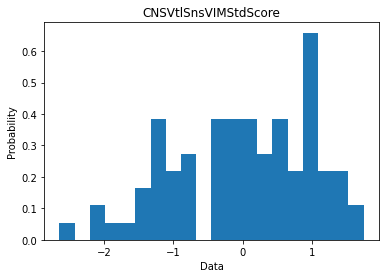

In [25]:
# within 2 month
scores = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])).isin([0,1])]['CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore'].values
scores = (scores - np.mean(scores)) / np.std(scores)
plt.hist(scores, density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title('CNSVtlSnsVIMStdScore')

<ipython-input-37-7606280c36fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_Impact_4t['key3'] = merged_Impact_4t['CNSVitalSignsDomainScores.Main.GUID'] +'-' + merged_Impact_4t['CNSVitalSignsDomainScores.Main.SubjectIDNum'].apply(lambda x:str(int(x)))


Text(0.5, 1.0, 'CNSVtlSnsVIMStdScore')

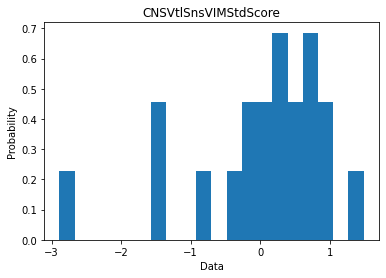

In [37]:
a = df_timelap.loc[(df_timelap['6 months post-injury'] - df_timelap['24-48 hours']).apply(lambda x:x.days) >= 60]
subjs = a.index.values
merged_Impact_4t['key3'] = merged_Impact_4t['CNSVitalSignsDomainScores.Main.GUID'] +'-' + merged_Impact_4t['CNSVitalSignsDomainScores.Main.SubjectIDNum'].apply(lambda x:str(int(x)))
df = merged_Impact_4t.loc[merged_Impact_4t['key2'].apply(lambda x: int(x.split('-')[-1])).isin([3])]
df = df.loc[df['key3'].isin(subjs)]
scores = df['CNSVitalSignsDomainScores.Visual Memory.CNSVtlSnsVIMStdScore'].values
scores = (scores - np.mean(scores)) / np.std(scores)
plt.hist(scores, density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title('CNSVtlSnsVIMStdScore')


In [3]:
df

NameError: name 'df' is not defined

Found besides b0 filed map, which has separate files. Some Diffusion data has eps_b0 as ImgMRIT1T2SeqName

Count how may rows does not sepecify eps_b0 

In [2]:
all_dti_info = pd.read_csv('../common_data/query_result_ImagingDiffusion_2019-07-17T15-35-37668336643334196993.csv')
key = 'ImagingDiffusion.Magnetic Resonance Information.ImgMRIT1T2SeqName'
df = all_dti_info.dropna(axis=0, subset=['ImagingDiffusion.Main.GUID'])
df_not_b0 = df[df[key].isna()]
print(f"{df_not_b0.shape[0]} non-b0-fieldmap rows does not sepcify esp_b0 as T1T2 sequence")

300 non-b0-fieldmap rows does not sepcify esp_b0 as T1T2 sequence


In [4]:
label_count = list(zip(*np.unique(df_not_b0['ImagingDiffusion.Main.CaseContrlInd'].values, return_counts=True)))
print(f"Thier label distribution are : {label_count}")

Thier label distribution are : [('Case', 107), ('Control', 193)]


In [5]:
timept_count = list(zip(*np.unique(df_not_b0['ImagingDiffusion.Main.GeneralNotesTxt'].values, return_counts=True)))
print("Thier timepoint distribution are :")
print(timept_count)

Thier timepoint distribution are :
[('24-48 hours', 83), ('6 months post-injury', 56), ('7 days Post-Unrestricted Return to Play', 81), ('Asymptomatic', 80)]


In [6]:
guid_num = len(set(df_not_b0['ImagingDiffusion.Main.GUID'].values))
print(f'{guid_num} unique guids')

91 unique guids


Check Sequence

In [37]:
avail_dti_info = pd.read_csv('./dti_info.csv')

In [38]:
d = collections.defaultdict(list)
for i, row in avail_dti_info.iterrows():
    guid = row['ImagingDiffusion.Main.GUID']
    subjid = str(int(row['ImagingDiffusion.Main.SubjectIDNum']))
    timepoint = row['ImagingDiffusion.Main.GeneralNotesTxt']
    filename = row['save_dir']
    key = guid+'-'+subjid+'-'+timepoint
    d[key].append(filename)
    
    

In [48]:
d_id = {k:sorted([int(f.split('.')[-2].split('_')[-1]) for f in v ]) for k,v in d.items()}

In [49]:
id1 = [v[0] for k, v in d_id.items()]

In [50]:
list(zip(*np.unique(id1, return_counts=True)))

[(6, 1),
 (7, 72),
 (8, 266),
 (9, 14),
 (10, 5),
 (11, 105),
 (12, 13),
 (13, 1),
 (15, 1)]

In [51]:
d_id['TBINM872KDP-2168-6 months post-injury']

[7, 13, 14, 15, 16]

In [77]:
path = '../Diffusion_Imaging/'
folders = [os.path.join(path,x) for x in os.listdir(path)]
seqs = []
for folder in folders:
    walk = list(os.walk(folder))
    seqs.append([walk[0][0],walk[2][1]])

In [82]:
seqs = np.array(seqs, dtype=object)
for i in sorted(np.unique(seqs[:,1])):
    if 'PA' in i:
        continue
    print(i)

['10-ep2d_diff_30dir_b1000_b2000_AP']
['10-ep2d_diff_30dir_b1000_b2000_AP_CHECK_PHASE']
['10-ep2d_diff_b0_PA']
['11-SB_DTI_MCW']
['11-ep2d_diff_30dir_b1000_b2000_AP']
['11-ep2d_diff_30dir_b1000_b2000_AP_CHECK_PHASE']
['11-ep2d_diff_b0_PA']
['12-SB_DTI_MCW']
['12-ep2d_diff_30dir_b1000_b2000_AP']
['12-ep2d_diff_30dir_b1000_b2000_AP_CHECK_PHASE']
['12-ep2d_diff_b0_PA']
['13-SB_DTI_MCW']
['13-ep2d_diff_b0_PA']
['14-SB_DTI_MCW']
['14-ep2d_diff_b0_AP_1']
['14-ep2d_diff_b0_PA']
['15-SB_DTI_MCW']
['15-ep2d_diff_30dir_b1000_b2000_AP']
['15-ep2d_diff_b0_AP_1']
['15-ep2d_diff_b0_AP_2']
['15-ep2d_diff_b0_PA']
['16-SB_DTI_MCW']
['16-ep2d_diff_30dir_b1000_b2000_AP']
['16-ep2d_diff_b0_AP_1']
['16-ep2d_diff_b0_AP_2']
['16-ep2d_diff_b0_AP_3']
['16-ep2d_diff_b0_PA']
['17-ep2d_diff_b0_AP_2']
['17-ep2d_diff_b0_AP_3']
['18-ep2d_diff_b0_AP_3']
['23-ep2d_diff_30dir_b1000_b2000_AP']
['27-ep2d_diff_30dir_b1000_b2000_AP']
['28-ep2d_diff_b0_PA']
['38-ep2d_diff_b0_PA']
['4-ep2d_diff_30dir_b1000_b2000_AP']
['5-ep2

In [85]:
counts = [x for x in zip(*np.unique(seqs[:,1], return_counts=True)) if "PA" not in x[0]]

In [87]:
sorted(counts, key=lambda x:x[1], reverse=True)

[(['8-ep2d_diff_30dir_b1000_b2000_AP'], 521),
 (['9-ep2d_diff_b0_PA'], 423),
 (['11-SB_DTI_MCW'], 262),
 (['8-ep2d_diff_30dir_b1000_b2000_AP_CHECK_PHASE'], 121),
 (['13-ep2d_diff_b0_PA'], 72),
 (['7-ep2d_diff_30dir_b1000_b2000_AP'], 72),
 (['14-ep2d_diff_b0_AP_1'], 71),
 (['15-ep2d_diff_b0_AP_2'], 71),
 (['16-ep2d_diff_b0_AP_3'], 71),
 (['12-SB_DTI_MCW'], 28),
 (['9-ep2d_diff_30dir_b1000_b2000_AP'], 28),
 (['10-ep2d_diff_b0_PA'], 26),
 (['9-ep2d_diff_30dir_b1000_b2000_AP_CHECK_PHASE'], 13),
 (['10-ep2d_diff_30dir_b1000_b2000_AP'], 12),
 (['11-ep2d_diff_b0_PA'], 11),
 (['13-SB_DTI_MCW'], 6),
 (['14-ep2d_diff_b0_PA'], 5),
 (['12-ep2d_diff_b0_PA'], 4),
 (['15-ep2d_diff_b0_AP_1'], 4),
 (['16-ep2d_diff_b0_AP_2'], 4),
 (['17-ep2d_diff_b0_AP_3'], 4),
 (['11-ep2d_diff_30dir_b1000_b2000_AP'], 3),
 (['15-SB_DTI_MCW'], 2),
 (['15-ep2d_diff_30dir_b1000_b2000_AP'], 2),
 (['16-ep2d_diff_b0_PA'], 2),
 (['10-ep2d_diff_30dir_b1000_b2000_AP_CHECK_PHASE'], 1),
 (['11-ep2d_diff_30dir_b1000_b2000_AP_CHECK_

In [90]:
avail_dti_info.loc[avail_dti_info['ImagingDiffusion.Main.GUID'] == 'TBIZN166LJY']

,file_key,Study ID,Dataset,ImagingDiffusion.Main.GUID,ImagingDiffusion.Main.SubjectIDNum,ImagingDiffusion.Main.AgeYrs,ImagingDiffusion.Main.VisitDate,ImagingDiffusion.Main.SiteName,ImagingDiffusion.Main.DaysSinceBaseline,ImagingDiffusion.Main.CaseContrlInd,...,ImagingDiffusion.Diffusion Direction Data.ImgT2WSpinEchoAcquireInd,ImagingDiffusion.Diffusion Direction Data.ImgDiffusionBValFile,ImagingDiffusion.Diffusion Direction Data.ImgDiffusionBVecFile,ImagingDiffusion.Diffusion Derived Data.ImgDiffusionDerivedDataTyp,ImagingDiffusion.Diffusion Derived Data.ImgDiffusionDerivedDataTypOTH,ImagingDiffusion.Diffusion Derived Data.ImgFile,ImagingDiffusion.Diffusion Measurements.ImgDiffusionMeasrTyp,ImagingDiffusion.Diffusion Measurements.ImgDiffusionMeasrOTH,ImagingDiffusion.Diffusion Measurements.ImgDiffusionReslt,save_dir
920,TBIZN166LJY_ImagingDiffusion_FwI5HfqsmyMup5jdJ...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-02-28T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
940,TBIZN166LJY_ImagingDiffusion_Q0yPvu3FovZb3aBuD...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-03-20T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
956,TBIZN166LJY_ImagingDiffusion_zktD1NO6yl5KGPLEg...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-05-22T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
971,TBIZN166LJY_ImagingDiffusion_ubFzaCAVEV1AYAkmR...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-03-07T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
991,TBIZN166LJY_ImagingDiffusion_Q0yPvu3FovZb3aBuD...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-03-20T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
1006,TBIZN166LJY_ImagingDiffusion_FwI5HfqsmyMup5jdJ...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-02-28T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
1023,TBIZN166LJY_ImagingDiffusion_ubFzaCAVEV1AYAkmR...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-03-07T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...
1044,TBIZN166LJY_ImagingDiffusion_zktD1NO6yl5KGPLEg...,310.0,FITBIR-DATA0006025,TBIZN166LJY,3788.0,19.0,2018-05-22T00:00:00Z,NaN,NaN,Control,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/gpfs/data/luilab/FITBIR_META_DATA/updated_dat...


In [91]:
avail_dti_info.columns

Index(['file_key', 'Study ID', 'Dataset', 'ImagingDiffusion.Main.GUID',
       'ImagingDiffusion.Main.SubjectIDNum', 'ImagingDiffusion.Main.AgeYrs',
       'ImagingDiffusion.Main.VisitDate', 'ImagingDiffusion.Main.SiteName',
       'ImagingDiffusion.Main.DaysSinceBaseline',
       'ImagingDiffusion.Main.CaseContrlInd',
       ...
       'ImagingDiffusion.Diffusion Direction Data.ImgT2WSpinEchoAcquireInd',
       'ImagingDiffusion.Diffusion Direction Data.ImgDiffusionBValFile',
       'ImagingDiffusion.Diffusion Direction Data.ImgDiffusionBVecFile',
       'ImagingDiffusion.Diffusion Derived Data.ImgDiffusionDerivedDataTyp',
       'ImagingDiffusion.Diffusion Derived Data.ImgDiffusionDerivedDataTypOTH',
       'ImagingDiffusion.Diffusion Derived Data.ImgFile',
       'ImagingDiffusion.Diffusion Measurements.ImgDiffusionMeasrTyp',
       'ImagingDiffusion.Diffusion Measurements.ImgDiffusionMeasrOTH',
       'ImagingDiffusion.Diffusion Measurements.ImgDiffusionReslt',
       'save_dir'],


In [102]:
GUID = 'TBIZN166LJY'
demo = pd.read_csv('../common_data/query_result_DemogrFITBIR_Appdx_0000310_2019-07-17T15-33-431463475851249904201.csv', low_memory=False)
A = demo.loc[demo['DemogrFITBIR_Appdx_0000310.Main.GUID']==GUID]
print(avail_dti_info.loc[avail_dti_info['ImagingDiffusion.Main.GUID'] == 'TBIZN166LJY']['ImagingDiffusion.Main.AgeYrs'])
print(A['DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt'])


920     19.0
940     19.0
956     19.0
971     19.0
991     19.0
1006    19.0
1023    19.0
1044    19.0
Name: ImagingDiffusion.Main.AgeYrs, dtype: float64
40417    Male
Name: DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt, dtype: object


In [108]:
controls = avail_dti_info.loc[avail_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Control']

In [110]:
gender_map = {row['DemogrFITBIR_Appdx_0000310.Main.GUID']:row['DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt'] for i, row in demo.iterrows()}

In [116]:
genders = [gender_map[guid] for guid in controls['ImagingDiffusion.Main.GUID'].values]
controls['gender'] = genders
male_controls = controls.loc[controls['gender']=='Male']



<ipython-input-116-78d07aa1f729>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  controls['gender'] = genders


array(['/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBIJD290WER_ImagingDiffusion_1566917373323_PYqdXaShoweFFXKiR9ZwrzNtv_15.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBIEX362VH3_ImagingDiffusion_1566918578460_yiZTsLK1FJV5x7R4KwtvEMG4x_14.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBINM872KDP_ImagingDiffusion_1566917933713_8oIWtMOAZjOgvHapATqLSzPQa_7.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBIMX094ZTC_ImagingDiffusion_1566916826677_vs3g74HBQ9jLRyR6d5R1YiGF1_16.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBIUV221NTZ_ImagingDiffusion_1566919205604_wWLdQeKLiutNsegxWsr1y0Ugl_13.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBICX014CFL_ImagingDiffusion_1566917367644_g9XU9MIR1NQEt07QBp1jwTcWU_13.zip',
       '/gpfs/data/luilab/FITBIR_META_DAT

In [9]:
# read demo info 
DemogrFITBIR = pd.read_csv('../common_data/query_result_DemogrFITBIR_2019-07-17T15-28-374403404190046158541.csv',low_memory=False)
DemogrFITBIRAppdx = pd.read_csv('../common_data/query_result_DemogrFITBIR_Appdx_0000310_2019-07-17T15-33-431463475851249904201.csv',low_memory=False)
contactsports = ['Football', 'Ice hockey', 'Lacrosse', 'Soccer']

In [18]:
# no site name 
print(DemogrFITBIR.dropna(subset=['DemogrFITBIR.Main Group.SiteName']).shape)
# no case/control 
print(DemogrFITBIR.dropna(subset=['DemogrFITBIR.Main Group.CaseContrlInd']).shape)
# no adminostrator 
print(DemogrFITBIR.dropna(subset=['DemogrFITBIR.Form Administration.ContextType']).shape)

(0, 139)
(0, 139)
(0, 139)


In [8]:
np.unique(all_dti_info[all_dti_info['cohort']==1]['ImagingDiffusion.Main.CaseContrlInd'].values, return_counts=True)

(array(['Control'], dtype=object), array([612]))

In [19]:
np.unique(all_dti_info[all_dti_info['cohort']==1]['ImagingDiffusion.Main.CaseContrlInd'].values, return_counts=True)

(array(['Case', 'Control'], dtype=object), array([ 40, 612]))

In [10]:
allcasesids = all_dti_info.loc[all_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Case']
allcasesids = allcasesids['ImagingDiffusion.Main.GUID'].values
cases_DemogrFITBIRAppdx = DemogrFITBIRAppdx.loc[DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].isin(allcasesids)]
cases_DemogrFITBIRAppdx = cases_DemogrFITBIRAppdx.drop_duplicates(subset=['DemogrFITBIR_Appdx_0000310.Main.GUID'])
sporttypes_cases = cases_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].values
sporttypes = np.unique(sporttypes_cases, return_counts=True)
print('case sport type:')
print(list(zip(*sporttypes)))
genders = cases_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt'].values
genders = np.unique(genders, return_counts=True)
print('case gender type:')
print(list(zip(*genders)))


case sport type:
[('Football', 69), ('Ice hockey', 9), ('Lacrosse', 8), ('Soccer', 28)]
case gender type:
[('Female', 19), ('Male', 95)]


In [11]:
allcontrolids = all_dti_info.loc[all_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Control']
allcontrolids = allcontrolids['ImagingDiffusion.Main.GUID'].values
allcontrol_DemogrFITBIRAppdx = DemogrFITBIRAppdx.loc[DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].isin(allcontrolids)]
allcontrol_DemogrFITBIRAppdx = allcontrol_DemogrFITBIRAppdx.drop_duplicates(subset=['DemogrFITBIR_Appdx_0000310.Main.GUID'])
sporttypes_control = allcontrol_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].values
sporttypes = np.unique(sporttypes_control, return_counts=True)
print('case sport type:')
print(list(zip(*sporttypes)))
genders = allcontrol_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt'].values
genders = np.unique(genders, return_counts=True)
print('case gender type:')
print(list(zip(*genders)))

case sport type:
[('Baseball', 37), ('Basketball', 12), ('Cross Country', 37), ('Field Event', 8), ('Football', 62), ('Ice hockey', 8), ('Lacrosse', 6), ('Soccer', 27), ('Softball', 7)]
case gender type:
[('Female', 40), ('Male', 164)]


In [24]:
len(set(allcontrolids))

204

In [27]:
allcontrol1_DemogrFITBIRAppdx = allcontrol_DemogrFITBIRAppdx.loc[
    allcontrol_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].isin(contactsports)
]
allcontrol1ids = allcontrol1_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].values
print(len(allcontrol1ids))

sporttypes = allcontrol1_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].values
sporttypes = np.unique(sporttypes, return_counts=True)
print('case sport type:')
print(list(zip(*sporttypes)))

103
case sport type:
[('Football', 62), ('Ice hockey', 8), ('Lacrosse', 6), ('Soccer', 27)]


In [28]:
allcontrol2_DemogrFITBIRAppdx = allcontrol_DemogrFITBIRAppdx.loc[
    ~allcontrol_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].isin(contactsports)
]
allcontrol2ids = allcontrol2_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].values
print(len(allcontrol2ids))

sporttypes = allcontrol2_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].values
sporttypes = np.unique(sporttypes, return_counts=True)
print('case sport type:')
print(list(zip(*sporttypes)))

101
case sport type:
[('Baseball', 37), ('Basketball', 12), ('Cross Country', 37), ('Field Event', 8), ('Softball', 7)]


In [14]:
print(set(allcontrol1ids) & set(allcontrol2ids))
print(set(allcasesids) & set(allcontrol1ids))
print(set(allcasesids) & set(allcontrol2ids))

set()
{'TBIZK127XMX', 'TBIJP385UKW', 'TBITC277FAU', 'TBIRH053MLX', 'TBIJY283VKB', 'TBICC177VED', 'TBIHK689VAG'}
set()


In [54]:
casesids = avail_dti_info.loc[avail_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Case']
casesids = casesids['ImagingDiffusion.Main.GUID'].values
cases_DemogrFITBIRAppdx = DemogrFITBIRAppdx.loc[DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].isin(casesids)]
cases_DemogrFITBIRAppdx = cases_DemogrFITBIRAppdx.drop_duplicates(subset=['DemogrFITBIR_Appdx_0000310.Main.GUID'])
sporttypes_cases = cases_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].values
sporttypes = np.unique(sporttypes_cases, return_counts=True)
print('case sport type:')
print(list(zip(*sporttypes)))
genders = cases_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt'].values
genders = np.unique(genders, return_counts=True)
print('case gender type:')
print(list(zip(*genders)))

case sport type:
[('Football', 31), ('Ice hockey', 7), ('Lacrosse', 5), ('Soccer', 15)]
case gender type:
[('Female', 11), ('Male', 47)]


In [55]:
controlids = avail_dti_info.loc[avail_dti_info['ImagingDiffusion.Main.CaseContrlInd'] == 'Control']
controlids = controlids['ImagingDiffusion.Main.GUID'].values
control_DemogrFITBIRAppdx = DemogrFITBIRAppdx.loc[DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].isin(controlids)]
control_DemogrFITBIRAppdx = control_DemogrFITBIRAppdx.drop_duplicates(subset=['DemogrFITBIR_Appdx_0000310.Main.GUID'])
sporttypes_control = control_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].values
sporttypes = np.unique(sporttypes_control, return_counts=True)
print('control sport type:')
print(list(zip(*sporttypes)))




control sport type:
[('Baseball', 23), ('Basketball', 3), ('Cross Country', 15), ('Field Event', 3), ('Football', 21), ('Ice hockey', 5), ('Lacrosse', 5), ('Soccer', 11), ('Softball', 3)]


In [56]:
control1_DemogrFITBIRAppdx = control_DemogrFITBIRAppdx.loc[
    control_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].isin(contactsports)
]
control1ids = control1_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].values
len(control1ids)



42

In [57]:
control2_DemogrFITBIRAppdx = control_DemogrFITBIRAppdx.loc[~control_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Sport History.SportTeamParticipationTyp'].isin(contactsports)]
control2ids = control2_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Main.GUID'].values
len(control2ids)

47

In [63]:
control2_male = control2_DemogrFITBIRAppdx[control2_DemogrFITBIRAppdx['DemogrFITBIR_Appdx_0000310.Demographics.GenderTypExt'] == 'Male']
control2_male_ids = control2_male['DemogrFITBIR_Appdx_0000310.Main.GUID'].values


In [68]:
control2_male_dti_info = avail_dti_info[avail_dti_info['ImagingDiffusion.Main.GUID'].isin(control2_male_ids)]

In [69]:
control2_male_dti_info.to_csv('control2_male_dti_info.csv')

In [37]:
all_dti_info[all_dti_info['ImagingDiffusion.Main.GUID'] == 'TBIJY283VKB'][['ImagingDiffusion.Main.GUID','ImagingDiffusion.Main.SubjectIDNum','ImagingDiffusion.Main.CaseContrlInd','cohort']]


,ImagingDiffusion.Main.GUID,ImagingDiffusion.Main.SubjectIDNum,ImagingDiffusion.Main.CaseContrlInd,cohort
1047,TBIJY283VKB,1833.0,Case,0
1086,TBIJY283VKB,1449.0,Control,1
1109,TBIJY283VKB,1833.0,Case,0
1140,TBIJY283VKB,1833.0,Case,0
1179,TBIJY283VKB,1449.0,Control,1
1210,TBIJY283VKB,1449.0,Control,1
1233,TBIJY283VKB,1833.0,Case,0
1248,TBIJY283VKB,1833.0,Case,0
1295,TBIJY283VKB,1449.0,Control,1
1326,TBIJY283VKB,1833.0,Case,0


In [38]:
set(avail_dti_info['ImagingDiffusion.Main.GUID'].values) & set(['TBIZK127XMX', 'TBIJP385UKW', 'TBITC277FAU', 'TBIRH053MLX', 'TBIJY283VKB', 'TBICC177VED', 'TBIHK689VAG'])

{'TBITC277FAU'}

In [ ]:
'TBITC277FAU'

In [41]:
avail_dti_info[avail_dti_info['ImagingDiffusion.Main.GUID']=='TBITC277FAU'][['ImagingDiffusion.Main.GUID','ImagingDiffusion.Main.SubjectIDNum','ImagingDiffusion.Main.GeneralNotesTxt','ImagingDiffusion.Main.CaseContrlInd','cohort']]

,ImagingDiffusion.Main.GUID,ImagingDiffusion.Main.SubjectIDNum,ImagingDiffusion.Main.GeneralNotesTxt,ImagingDiffusion.Main.CaseContrlInd,cohort
50,TBITC277FAU,2481.0,24-48 hours,Case,0
88,TBITC277FAU,2106.0,7 days Post-Unrestricted Return to Play,Control,1
184,TBITC277FAU,2841.0,Asymptomatic,Case,0
238,TBITC277FAU,2481.0,7 days Post-Unrestricted Return to Play,Case,0
309,TBITC277FAU,2841.0,24-48 hours,Case,0
363,TBITC277FAU,2481.0,Asymptomatic,Case,0
426,TBITC277FAU,2106.0,24-48 hours,Control,1
496,TBITC277FAU,2106.0,Asymptomatic,Control,1


In [43]:
avail_dti_info[avail_dti_info['ImagingDiffusion.Main.GUID']=='TBITC277FAU']['save_dir'].values

array(['/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBITC277FAU_ImagingDiffusion_1566919223568_jTc7tFlkGjkGiRzIpTJfBKQ39_11.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBITC277FAU_ImagingDiffusion_1566919223196_NHYgrnWwohTTwgiz79PHLe1E5_11.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBITC277FAU_ImagingDiffusion_1566919225448_raVRpLzdOQzKpFOPiGsEyldJ5_11.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBITC277FAU_ImagingDiffusion_1566919224630_BpniwCqJKI1XbyMA870sjr2Xt_11.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBITC277FAU_ImagingDiffusion_1566919224814_sfEOn3LwyatY7VBKEoD3xPkHi_11.zip',
       '/gpfs/data/luilab/FITBIR_META_DATA/updated_data/DTI_Final_1of4_082819_310/TBITC277FAU_ImagingDiffusion_1566919224189_PP2bptNl09Jv0JharoJH6kbC1_11.zip',
       '/gpfs/data/luilab/FITBIR_META_DA